# SRGAN

In [7]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline

In [8]:
# Location of model weights (needed for demo)
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [9]:
div2k_train = DIV2K(scale=4, subset='train', downgrade='bicubic')
div2k_valid = DIV2K(scale=4, subset='valid', downgrade='bicubic')

In [10]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=16, random_transform=True, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-srgan.tar.gz](https://martin-krasser.de/sisr/weights-srgan.tar.gz) and extract the archive in the project's root directory. This will create a folder `weights/srgan` containing the weights of the pre-trained models.

### Generator pre-training

In [ ]:
pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')
pre_trainer.train(train_ds,
                  valid_ds.take(10),
                  steps=1000000, 
                  evaluate_every=1000, 
                  save_best_only=False)

pre_trainer.model.save_weights(weights_file('pre_generator.h5'))

### Generator fine-tuning (GAN)

In [ ]:
gan_generator = generator()
gan_generator.load_weights(weights_file('pre_generator.h5'))

gan_trainer = SrganTrainer(generator=gan_generator, discriminator=discriminator())
gan_trainer.train(train_ds, steps=200000)

80142336/80134624 [==============================] - 11s 0us/step
50/200000, perceptual loss = 0.0825, discriminator loss = 1.8575
100/200000, perceptual loss = 0.0757, discriminator loss = 1.2892


In [ ]:
gan_trainer.generator.save_weights(weights_file('gan_generator.h5'))
gan_trainer.discriminator.save_weights(weights_file('gan_discriminator.h5'))

## Demo

In [11]:
pre_generator = generator()
gan_generator = generator()

pre_generator.load_weights(weights_file('pre_generator.h5'))
gan_generator.load_weights(weights_file('gan_generator.h5'))

In [12]:
from model import resolve_single
from utils import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    gan_sr = resolve_single(gan_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr, gan_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

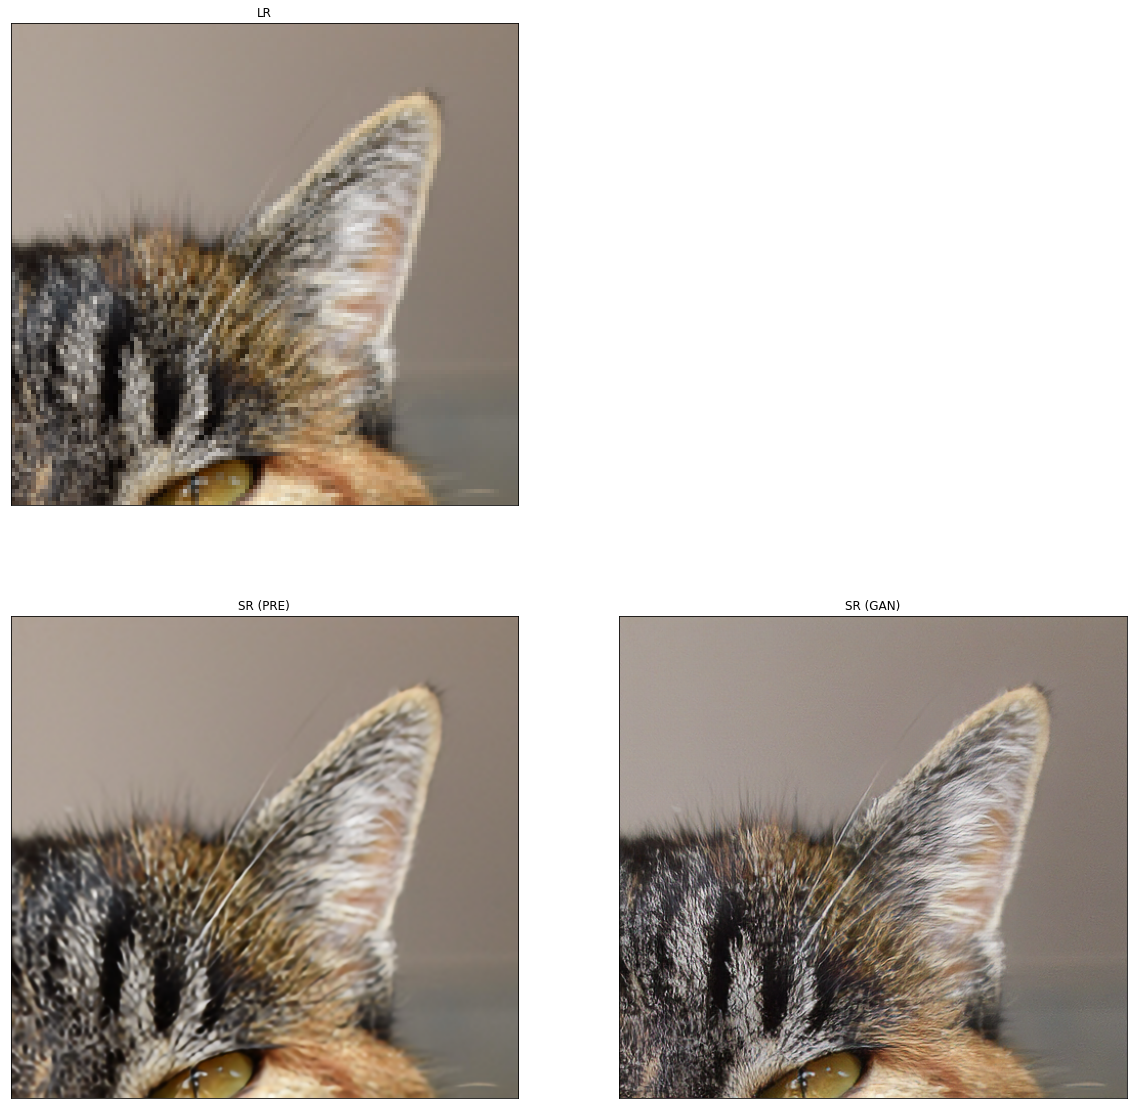

In [13]:
resolve_and_plot('demo/0869x4-crop.png')
plt.savefig("demo1.png")

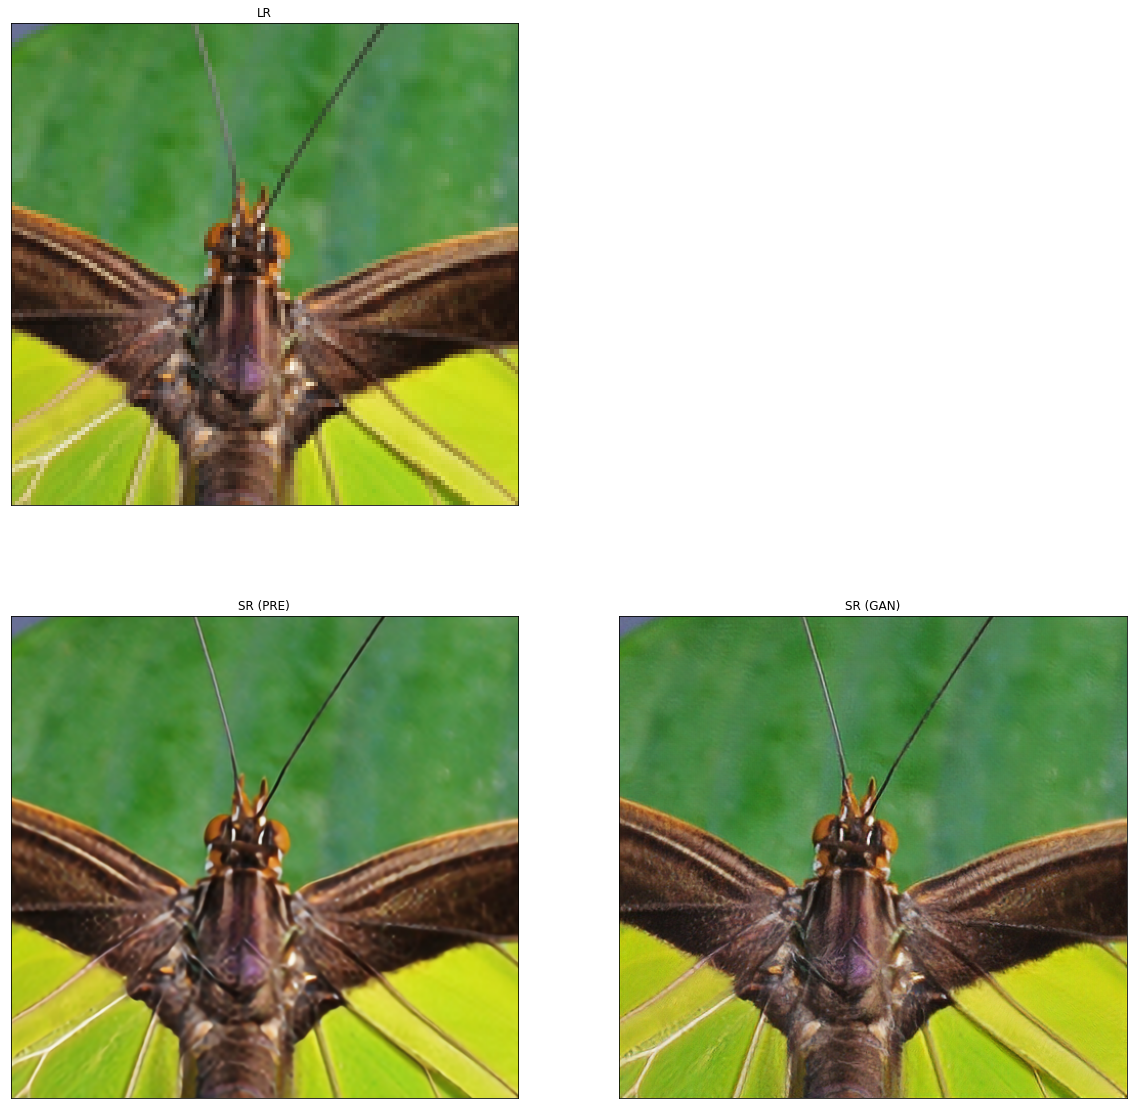

In [14]:
resolve_and_plot('demo/0829x4-crop.png')
plt.savefig("demo2.png")

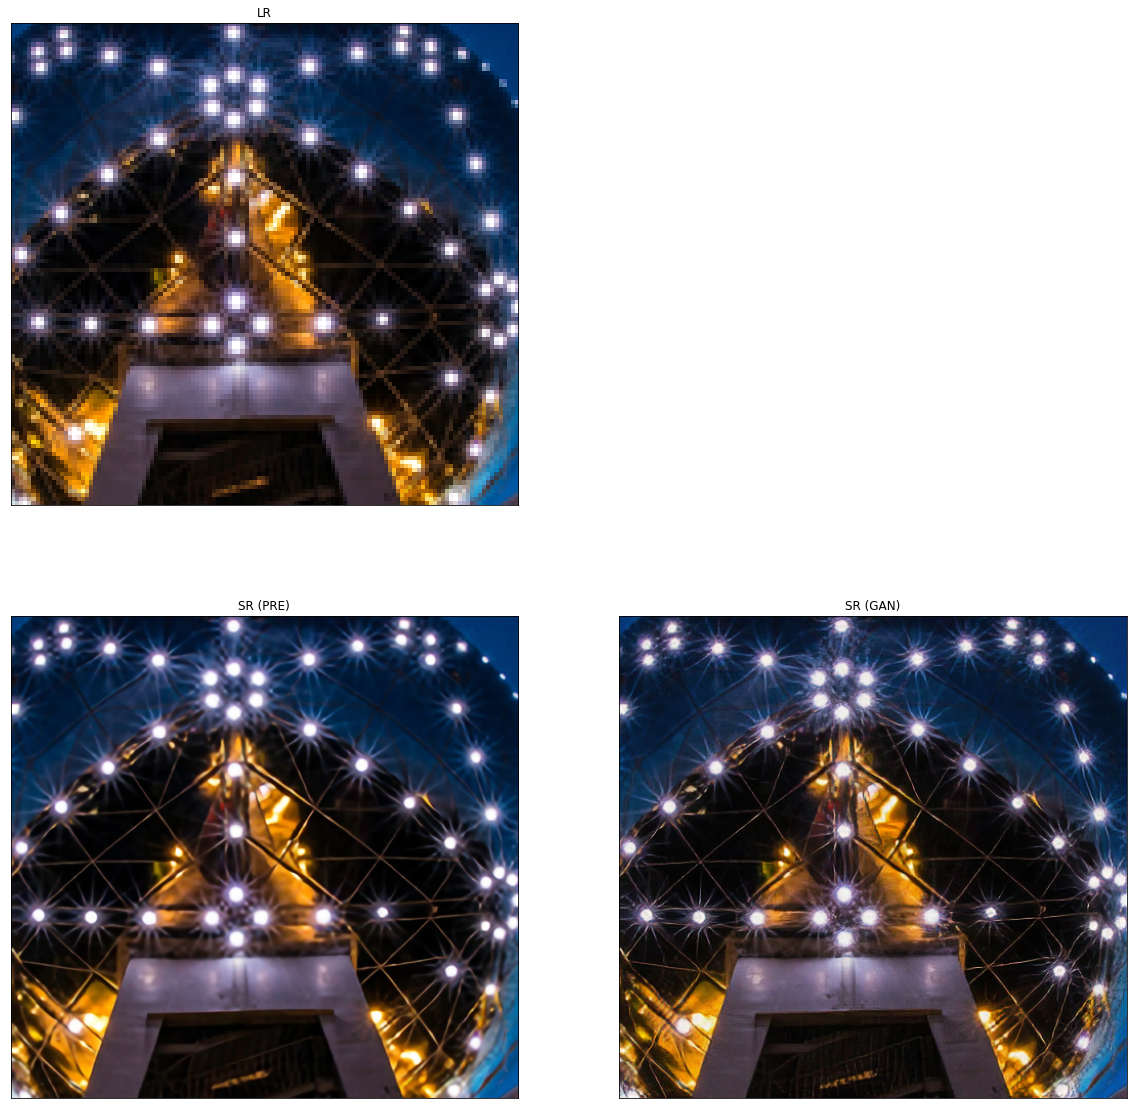

In [15]:
resolve_and_plot('demo/0851x4-crop.png')
plt.savefig("demo3.png")